In [15]:
# %config InlineBackend.figure_format = 'svg'
%matplotlib inline

from collections import namedtuple
from functools import partial
from pathlib import Path

from IPython.display import Audio

import librosa as lr
from librosa import display

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (13, 5)

import numpy as np

In [2]:
def find_file(query, path):
    """Return a path to file in path if query is in filename. Raise FileNotFoundError if it does not exist."""
    file = sorted(p for p in path.iterdir() if query in p.name)[0]
    if not file.exists():
        raise FileNotFoundError
    return file

TrackClip = namedtuple('TrackClip', 'path start stop')

In [3]:
cwd = Path.cwd()
uncut = cwd / 'uncut'

find_song = partial(find_file, path=uncut)

hey_oh = TrackClip(find_song('hey_oh'), 0.0, 4.53)
funky_monks = TrackClip(find_song('funky_monks'), 11.27, 16.73)

# Step 1: Retrieve Audio

In [53]:
track_clip = funky_monks

y, sr = lr.load(track_clip.path, 
                offset=track_clip.start, 
                duration=track_clip.stop - track_clip.start, 
#                 res_type='kaiser_fast',
               )
y.shape, sr, divmod(lr.get_duration(y), 60)

((120393,), 22050, (0.0, 5.46))

In [54]:
Audio(data=y, rate=sr)

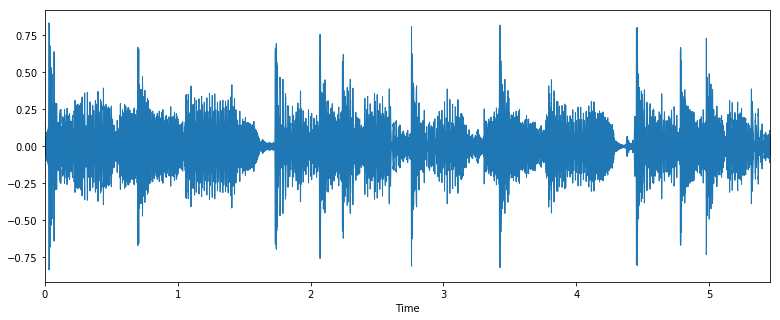

In [55]:
lr.display.waveplot(y=y);

In [56]:
D = lr.stft(y=y)

In [57]:
Dmag = lr.amplitude_to_db(np.abs(D))

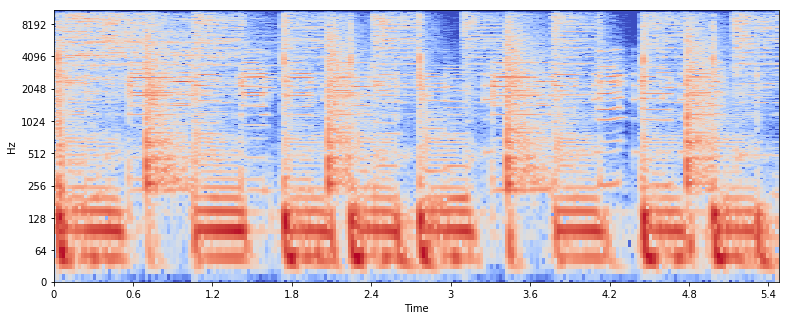

In [58]:
lr.display.specshow(Dmag, x_axis='time', y_axis='log');

# Step 2: Detect Onsets

In [59]:
onset_frames = lr.onset.onset_detect(y)
onset_frames

array([  3,  19,  25,  31,  47,  62,  75,  90,  98, 105, 120, 134, 144,
       148, 164, 178, 192, 207, 216, 222, 230])

In [60]:
onset_times = lr.frames_to_time(onset_frames)
onset_times.round(2)

array([0.07, 0.44, 0.58, 0.72, 1.09, 1.44, 1.74, 2.09, 2.28, 2.44, 2.79,
       3.11, 3.34, 3.44, 3.81, 4.13, 4.46, 4.81, 5.02, 5.15, 5.34])

In [61]:
onset_samples = lr.frames_to_samples(onset_frames)
onset_samples

array([  1536,   9728,  12800,  15872,  24064,  31744,  38400,  46080,
        50176,  53760,  61440,  68608,  73728,  75776,  83968,  91136,
        98304, 105984, 110592, 113664, 117760])

In [62]:
clicks = lr.clicks(times=onset_times, length=len(y))
Audio(y + clicks, rate=sr)

# Step 3: Segment the Audio

In [63]:
frame_size = int(0.100 * sr)  # 100 ms
segments = np.array([y[i:i+frame_size] for i in onset_samples])

In [64]:
def concatenate_segments(segments, sr=22050, pad_time=0.300):
    padded_segments = [np.concatenate([segment, np.zeros(int(pad_time*sr))]) for segment in segments]
    return np.concatenate(padded_segments)

In [65]:
concatenated_signal = concatenate_segments(segments, sr)
Audio(concatenated_signal, rate=sr)

# Step 4: Extract Features

In [151]:
zero_crossings = [lr.zero_crossings(segment).sum() for segment in segments]
# zero_crossings

In [70]:
indices = np.argsort(zero_crossings)
indices

array([18, 10,  8, 16,  6,  4, 14, 15,  5, 13,  7, 12, 17,  1,  3,  9, 20,
       19,  2, 11,  0])

In [73]:
concatenated_signal = concatenate_segments(segments[indices])
Audio(concatenated_signal, rate=sr)

# ZCRs may not work well with polyphonic
may need to first separate the harmonic from percussive elements

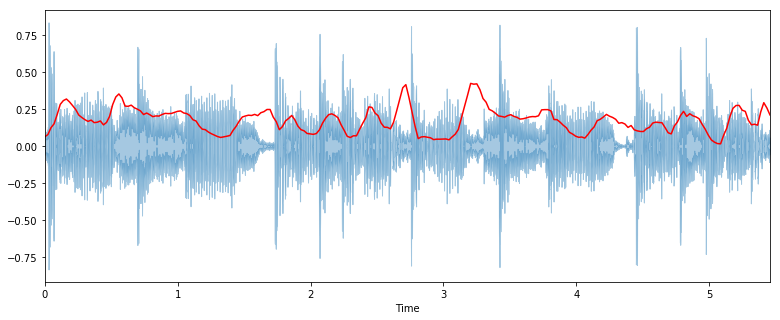

In [239]:
zcrs = lr.feature.zero_crossing_rate(y)
times = lr.frames_to_time(np.arange(zcrs.shape[1]))

lr.display.waveplot(y=y, x_axis='time', alpha=0.4)
plt.plot(times, zcrs[0], color='r');  # do NOT use x=times, y=zcrs[0]!

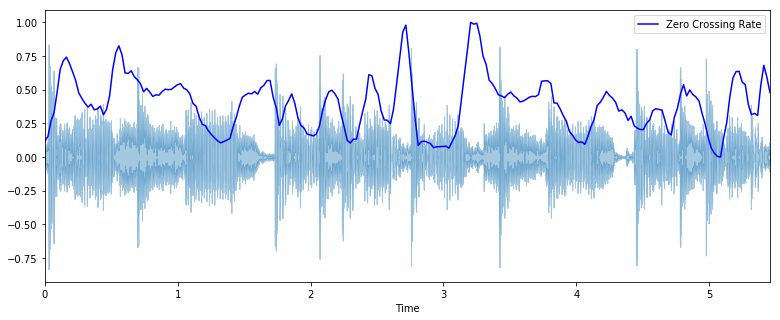

In [249]:
import sklearn.preprocessing

def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

zcr = lr.feature.zero_crossing_rate(y)[0]
frames = range(len(zcr))
times = lr.frames_to_time(frames)

lr.display.waveplot(y, alpha=0.4, x_axis='time')
# plt.plot(times, zcr, 'r')
plt.plot(times, normalize(zcr), 'b', label='Zero Crossing Rate')
plt.legend();

In [234]:
(lr.frames_to_time(np.arange(zcrs.shape[1])) == lr.frames_to_time(range(len(zcr)))).all()

True

In [235]:
(zcr == zcrs[0]).all()

True

# Testing Mag|Phase vs Abs

* `D` is a STFT
* `S` = `D_mag` is a spectrogram
* `P` = `D_phase`

In [177]:
D = lr.stft(y)
D.shape

(1025, 236)

In [179]:
D_mag, D_phase = lr.magphase(D)
D_mag.shape, D_phase.shape

((1025, 236), (1025, 236))

In [180]:
S = np.abs(D)
S.shape

(1025, 236)

In [183]:
(D_mag == S).all()

True

In [211]:
(abs(D) == S).all()

True

# Timeit

In [214]:
%timeit abs(D)

733 µs ± 4.31 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [215]:
%timeit np.abs(D)

735 µs ± 6.56 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [216]:
%timeit sum(D)

1.51 ms ± 46.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [217]:
%timeit np.sum(D)

125 µs ± 1.83 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
